# Hartree-Fock con omisión de electron self-interaction

Alejandra Mendez

In [1]:
%matplotlib inline

In [2]:
from numpy import sqrt, exp, linspace, zeros, identity, array, diag, c_, pi
from math import factorial
from numpy.linalg import eigh
from scipy.integrate import quad
from scipy.special import hyp1f1
from matplotlib.pyplot import plot, axis, title, xlabel, ylabel, show,\
                              legend, subplot

In [3]:
# Normalización de las funciones 
def Normalizate(U,x):
    h = x[1]-x[0] # assume uniformly spaced points
    n = len(x)
    for j in range(0,n-1):
        suma = 0.0
        for i in range(0,n-1):
             suma = suma + U[i,j]**2
        suma = suma*h 
        rnorm = 1/sqrt(suma)
#       Normalization
        rsign = 1
        if U[1,j] < 0:
            rsign = -1
        rnorm = rnorm * rsign
        for i in range(0,n):
            U[i,j] = U[i,j]*rnorm
    return  U

In [4]:
def Laplacian(x):
    h = x[1]-x[0] # assume uniformly spaced points
    n = len(x)
    M = -2*identity(n,'d')
    for i in range(1,n):
        M[i,i-1] = M[i-1,i] = 1
    return M/h**2

In [5]:
# Defino las dimensiones de los arrays a utilizar
nsize = 1000
rmax = 10.0
h = rmax/nsize
rmin = h

In [6]:
print(h)

0.01


In [7]:
# Defino las matrices y vectores necesarios
r = linspace(rmin,rmax,nsize)
T = array([nsize,nsize])
Vs = array([nsize,nsize])
U = zeros([nsize,nsize])
H = array([nsize,nsize])
E = array([nsize])

In [8]:
Upp = zeros(nsize)
Up = zeros(nsize)
Zh = zeros(nsize)
Vh = zeros(nsize)
den = zeros(nsize)

In [9]:
# Defino el sistema a resolver: Helio en el estado fundamental
Z = 2
l = 0

La ecuación de Kohn-Sham está dada por 
\begin{equation}
  \left[-\frac{1}{2}\nabla^2 + V_{\mathrm{s}}\left(n|\mathbf{r}\right)\right] \phi_i = \epsilon_i \phi_i
\end{equation}

donde

\begin{equation}
  V_{\mathrm{s}}(n|\mathbf{r}) = V_{\mathrm{ext}}(r) + V_{\mathrm{H}}^*(n|\mathbf{r})
\end{equation}

El potencial de Hartree en el esquema no-self interaction del Helio está dado por:

\begin{equation}
   V_{\mathrm{H}}^*(n|\mathbf{r}) = \int{d\mathbf{r}\,\frac{n_i(\mathbf{r}')}{|\mathbf{r}-\mathbf{r}'|}}
\end{equation}

donde $n_i(r)=\left|\phi_i\right|^2$ es la densidad single orbital.

\begin{equation}
   \quad \Rightarrow \quad 
   \nabla^2 V_{\mathrm{H}}^*(n|\mathbf{r}) = -4\pi \, n_{\mathrm{s}}(\mathbf{r})
\end{equation}

Debido a la simetría radial de la densidad,

\begin{equation}
  Z_{\mathrm{H}}(r) = r V_{\mathrm{H}}^*(r) 
   \quad \Rightarrow \quad 
   \frac{d^2 Z_{\mathrm{H}}(r)}{dr^2} = -4\pi \, r\,n_{\mathrm{s}}(r)
\end{equation}

Resuelvo usando el algoritmo de Verlet, e imponiendo dos condiciones 
de borde

\begin{equation}
  Z_{\mathrm{H}}(0) = 0
  \quad \mbox{y} \quad  
  Z_{\mathrm{H}}(r_{\mathrm{max}}) = q = 1
\end{equation}

In [10]:
# Defino la densidad SINGLE orbital
def densidad():
    noc = 1.0      # nro de ocupacion = 1 
    ang = 1.0/(4.0*pi)
    for i in range(nsize):
        den[i] = noc*(U[i,0]/r[i])**2*ang
    return den

In [11]:
# Defino el potencial de Hartree
# Uso el índice j (nro de iteracion) para no incluir el potencial Vh 
# en la primera iteración
def VHartree(j):
    if (j>0):
        # 1ra condicion de borde
        Up[0] = 0.0
        Zh[0] = 0.0
        Zh[1] = h
        for i in range(nsize):
            Upp[i] = -4.0*pi*den[i]*r[i]
        for i in range(nsize-1):
            Up[i+1] = Up[i] + 0.5*(Upp[i] + Upp[i+1])*h 
        # 2da condicion de borde
        alfa = -Up[nsize-1]
        for i in range(nsize-1):
            Zh[i+1] = Zh[i] + Up[i]*h + 0.5*Upp[i]*h**2 
        for i in range(nsize):
            Zh[i] = Zh[i] + alfa*r[i]
        for i in range(nsize):
            Vh[i] = Zh[i]/r[i]
    return Vh

In [12]:
# Inicializo algunas variables utiles en la iteración
# j : nro de iteraciones
j = 0
Eorb = []
Etotal = []
u0 = zeros((nsize,1))

## Empieza loop

In [86]:
# Calculo la densidad y el potencial de Hartree
densidad()
VHartree(j)

# Construyo el operador T y el operador Vs (potencial efectivo)
T = (-0.5)*Laplacian(r)
Vs = -Z/r + l*(l+1)/(2*r**2) + Vh

In [87]:
# Construyo el Hamiltoniano del sistema
H =  T + diag(Vs)

In [88]:
# Calculo autovalores (E) y autovectores (U)
E,U = eigh(H)
j = j + 1

# Normalization
U = Normalizate(U,r)

In [89]:
# Corroboro normalización
suma = 0.0
for i in range(nsize):
    suma = suma + (U[i,0])**2
suma = suma*h
suma

1.0000000000000053

In [90]:
# Adjunto los resultados para ver los resultados de cada iteración
# Eorb : energías
# u0   : funciones radiales reducidas
Eorb.append(E[0])
Eorb

[-1.9998000399911799,
 -0.8205890492930652,
 -0.95076810882634399,
 -0.90859666407503659,
 -0.92059605610799722,
 -0.91703786157933165,
 -0.91808054386836768,
 -0.91777392735434171,
 -0.91786399995454304,
 -0.91783753195668016]

### El valor de la energía orbital 1s de HF es -0.917956

In [91]:
u0 = c_[u0,U[:,0]]
u0

array([[  0.00000000e+00,   5.54429408e-02,   4.38441030e-02, ...,
          4.65847201e-02,   4.65869774e-02,   4.65863141e-02],
       [  0.00000000e+00,   1.08690339e-01,   8.59591582e-02, ...,
          9.13303111e-02,   9.13347350e-02,   9.13334351e-02],
       [  0.00000000e+00,   1.59807402e-01,   1.26403475e-01, ...,
          1.34296848e-01,   1.34303349e-01,   1.34301439e-01],
       ..., 
       [  0.00000000e+00,   1.30455973e-08,   3.16915760e-06, ...,
          1.58299940e-06,   1.58201494e-06,   1.58230416e-06],
       [  0.00000000e+00,   8.69445713e-09,   2.11251806e-06, ...,
          1.05518913e-06,   1.05453290e-06,   1.05472569e-06],
       [  0.00000000e+00,   4.34644629e-09,   1.05618292e-06, ...,
          5.27551424e-07,   5.27223330e-07,   5.27319718e-07]])

La energía total en este esquema está dada por:

\begin{equation}
E = \sum_i \epsilon_i - \int{dr \, V_{\mathrm{H}}^*(r) \, u_i^2(r) }
\end{equation}


In [92]:
# Calculo la integral del potencial Vh*
suma = 0.0
for i in range(nsize):
    suma = suma + Vh[i]*U[i,0]**2
Eh = suma*h
print(Eh)

1.02568251558


In [93]:
# Calculo la energia total del sistema

Etot = 2.0*(E[0]) - Eh
Etotal.append(Etot)

print('Energía Total: ')
Etotal

Energía Total: 


[-3.9996000799823599,
 -2.727963096153851,
 -2.9032550015150207,
 -2.8493416316463094,
 -2.8649214841239732,
 -2.8603224850633664,
 -2.8616719599013241,
 -2.8612752818778229,
 -2.8613918246394263,
 -2.8613575794935064]

### El valor de la energía total 1s^2 de HF es -2.861680

## Fin loop

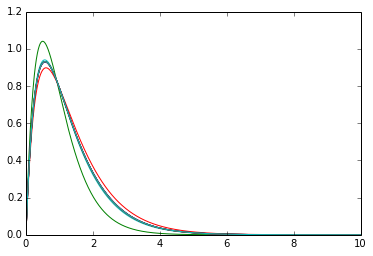

In [94]:
import matplotlib.pyplot as plt

%matplotlib inline


plt.plot(r,u0);